In [2]:
from datetime import datetime, timedelta
from flask import Flask, render_template
import json
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objects as go
import plotly.express as px
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time
import yaml

app = Flask(__name__)

In [3]:
class WeatherStation:
    def __init__(self):
        with open('settings.yaml', 'r') as file:
            settings = yaml.safe_load(file)

        self.station = settings['station']
        self.date = datetime.today().strftime("%Y-%m-%d")
        self.freq = settings['freq']
        self.chromedriver_path = settings['chromedriver_path']

    def get_settings(self):
        return self.station, self.date, self.freq, self.chromedriver_path

In [5]:
def render_page(url, chromedriver_path):
    """Given a url, render it with chromedriver and return the html source

    Parameters
    ----------
        url : str
            url to render
        chromedriver_path : str
            Path to location of chromedriver

    Returns
    -------
        r :
            rendered page source
    """
    chrome_service = Service(chromedriver_path)
    chrome_options = Options()
    chrome_options.add_argument("--headless=new")
    driver = webdriver.Chrome(service = chrome_service, options = chrome_options)
    driver.get(url)
    time.sleep(3) # Could potentially decrease the sleep time
    r = driver.page_source
    driver.quit()

    return r

def scrape_wunderground(station, date, freq, chromedriver_path):
    """Given a PWS station ID and date, scrape that day's data from Weather
    Underground and return it as a dataframe.

    Parameters
    ----------
        station : str
            The personal weather station ID
        date : str
            The date for which to acquire data, formatted as 'YYYY-MM-DD'
        freq : {'5min', 'daily'}
            Whether to download 5-minute weather observations or daily
            summaries (average, min and max for each day)
        chromedriver_path : str
            Path to the location of chromedriver

    Returns
    -------
        df : dataframe or None
            A dataframe of weather observations, with index as pd.DateTimeIndex
            and columns as the observed data
    """

    # the url for 5-min data is called "daily" on weather underground
    if freq == '5min':
        timespan = 'daily'
    # the url for daily summary data (avg/min/max) is called "monthly" on wunderground
    elif freq == 'daily':
        timespan = 'monthly'

    # Render the url and open the page source as BS object
    url = 'https://www.wunderground.com/dashboard/pws/%s/table/%s/%s/%s' % (station,
                                                                            date, date,
                                                                            timespan)
    r = render_page(url, chromedriver_path)
    soup = BS(r, "html.parser")

    container = soup.find('lib-history-table')

    # Check that lib-history-table is found
    if container is None:
        raise ValueError("could not find lib-history-table in html source for %s" % url)

    # Get the timestamps and data from two separate 'tbody' tags
    all_checks = container.find_all('tbody')
    time_check = all_checks[0]
    data_check = all_checks[1]

    # Iterate through 'tr' tags and get the timestamps
    hours = []
    for i in time_check.find_all('tr'):
        trial = i.get_text()
        hours.append(trial)

    # For data, locate both value and no-value ("--") classes
    classes = ['wu-value wu-value-to', 'wu-unit-no-value ng-star-inserted']

    # Iterate through span tags and get data
    data = []
    for i in data_check.find_all('span', class_=classes):
        trial = i.get_text()
        data.append(trial)

    columns = {'5min': ['Temperature', 'Dew Point', 'Humidity', 'Wind Speed',
                        'Wind Gust', 'Pressure', 'Precip. Rate', 'Precip. Accum.'],
            'daily': ['Temperature_High', 'Temperature_Avg', 'Temperature_Low',
                        'DewPoint_High', 'DewPoint_Avg', 'DewPoint_Low',
                        'Humidity_High', 'Humidity_Avg', 'Humidity_Low',
                        'WindSpeed_High', 'WindSpeed_Avg', 'WindSpeed_Low',
                        'Pressure_High', 'Pressure_Low', 'Precip_Sum']}

    # Convert NaN values (stings of '--') to np.nan
    data_nan = [np.nan if x == '--' else x for x in data]

    # Convert list of data to an array
    data_array = np.array(data_nan, dtype=float)
    data_array = data_array.reshape(-1, len(columns[freq]))

    # Prepend date to HH:MM strings
    if freq == '5min':
        timestamps = ['%s %s' % (date, t) for t in hours]
    else:
        timestamps = hours

    # Convert to dataframe
    df = pd.DataFrame(index=timestamps, data=data_array, columns=columns[freq])
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d %I:%M %p')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Timestamp'}, inplace=True)

    return df

def scrape_multiattempt(station, date, freq, chromedriver_path, attempts, wait_time):
    """Try to scrape data from Weather Underground. If there is an error on the
    first attempt, try again.

    Parameters
    ----------
        station : str
            The personal weather station ID
        date : str
            The date for which to acquire data, formatted as 'YYYY-MM-DD'
        freq : {'5min', 'daily'}
            Whether to download 5-minute weather observations or daily
            summaries (average, min and max for each day)
        chromedriver_path : str
            Path to the location of chromedriver
        attempts : int, default 4
            Maximum number of times to try accessing before failure
        wait_time : float, default 5.0
            Amount of time to wait in between attempts
        
    Returns
    -------
        df : dataframe or None
            A dataframe of weather observations, with index as pd.DateTimeIndex
            and columns as the observed data
    """

    # Try to download data limited number of attempts
    for n in range(attempts):
        try:
            df = scrape_wunderground(station, date, freq, chromedriver_path)
        except:
            # if unsuccessful, pause and retry
            time.sleep(wait_time)
        else:
            # if successful, then break
            break
    # If all attempts failed, return empty df
    else:
        df = pd.DataFrame()

    return df

def scrape_multidate(station, start_date, end_date, freq):
    """Given a PWS station ID and a start and end date, scrape data from Weather
        Underground for that date range and return it as a dataframe.

        Parameters
        ----------
            station : str
                The personal weather station ID
            start_date : str
                The date for which to begin acquiring data, formatted as 'YYYY-MM-DD'
            end_date : str
                The date for which to end acquiring data, formatted as 'YYYY-MM-DD'

        Returns
        -------
            df : dataframe or None
                A dataframe of weather observations, with index as pd.DateTimeIndex
                and columns as the observed data
        """
    # Convert end_date and start_date to datetime types
    end_date = datetime.strptime(end_date, '%Y-%m-%d').date()
    start_date = datetime.strptime(start_date, '%Y-%m-%d').date()

    # Calculate time delta
    delta = end_date - start_date

    # Create list dates and append all days within the start and end date to dates
    dates = []
    for i in range(delta.days + 1):
        day = start_date + timedelta(days=i)
        dates.append(day)
    dates = [date.strftime('%Y-%m-%d') for date in dates]

    # Repeat the station name in a list for as many dates are in the date range
    stations = [station] * len(dates)

    # Scrape wunderground for data from all dates in range and store in list of dateframes
    df_list = list(map(scrape_multiattempt, stations, dates, freq=freq))

    # Convert list of dataframes to one dataframe
    df = pd.concat(df_list)

    return df

def create_graphs(df):
    temperature = [
        go.Scatter(
            x = df['Timestamp'],
            y = df['Temperature','Dew Point'],
            mode='lines'
        )
    ]

    temperature_graph = json.dumps(temperature, cls=plotly.utils.PlotlyJSONEncoder)

    return json.dumps(temperature, cls=plotly.utils.PlotlyJSONEncoder)

def df_to_html(df, station, date):
    return df.to_html('%s_%s.html' % (station, date))

def df_to_csv(df, station, date):
    return df.to_csv('%s_%s.csv' % (station, date))

@app.route('/')
def index():
    return render_template('index.html', graphJSON=graph_objects)

In [7]:
ws = WeatherStation()

In [10]:
df = scrape_multiattempt(ws.station, ws.date, ws.freq, ws.chromedriver_path, attempts=4, wait_time=5.0)

In [15]:
from IPython.display import display

In [14]:
display(df)

,Timestamp,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip. Rate,Precip. Accum.
0,2024-09-16 00:04:00,77.0,62.5,61.0,1.7,2.8,30.15,0.0,0.0
1,2024-09-16 00:09:00,76.7,62.4,61.0,1.0,1.5,30.14,0.0,0.0
2,2024-09-16 00:14:00,76.6,62.4,62.0,1.8,3.1,30.15,0.0,0.0
3,2024-09-16 00:19:00,76.6,62.1,61.0,1.9,2.8,30.15,0.0,0.0
4,2024-09-16 00:24:00,76.5,62.5,62.0,0.2,0.4,30.15,0.0,0.0
...,...,...,...,...,...,...,...,...,...
184,2024-09-16 15:24:00,89.4,64.0,43.0,6.0,8.4,30.12,0.0,0.0
185,2024-09-16 15:29:00,90.0,64.8,44.0,3.1,4.6,30.13,0.0,0.0
186,2024-09-16 15:34:00,90.7,64.3,42.0,4.2,6.5,30.12,0.0,0.0
187,2024-09-16 15:39:00,90.1,63.6,42.0,5.1,7.3,30.12,0.0,0.0


In [28]:
temperature = go.Scatter(
    x = df['Timestamp'],
    y = df['Temperature'],
    name='temperature'
)

dewpoint = go.Scatter(
    x = df['Timestamp'],
    y = df['Dew Point'],
    name='dewpoint'
)

In [29]:
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots

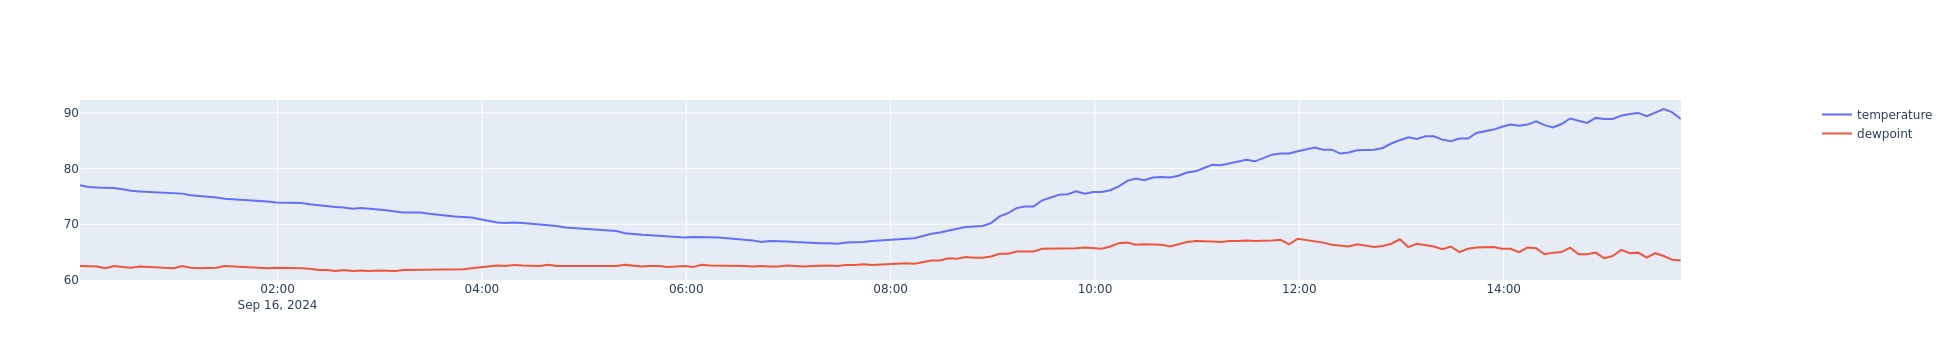

In [36]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(temperature)
fig.add_trace(dewpoint)
iplot(fig)